In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [113]:
smallset = pd.read_csv('filtered_data.csv')
largeset = pd.read_csv('remaining_data.csv')
print(f'Smaller set: {smallset.shape}')
print(f'Larger set: {largeset.shape}')

Smaller set: (359012, 24)
Larger set: (632334, 24)


In [114]:
file = 'filtered_data.csv'
df = pd.read_csv(file)

In [115]:
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,95.0,201.0,76.0,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
1,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,101.0,199.0,61.0,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N
2,Male,50,165,55,75.0,1.2,1.5,1.0,1.0,142.0,92.0,99.0,218.0,77.0,95.0,232.0,13.8,3.0,0.8,29.0,40.0,37.0,3.0,Y
3,Female,45,150,55,69.0,0.5,0.4,1.0,1.0,101.0,58.0,89.0,196.0,66.0,115.0,75.0,12.3,1.0,0.8,19.0,12.0,12.0,1.0,N
4,Male,55,170,75,84.0,1.2,0.9,1.0,1.0,145.0,85.0,104.0,217.0,56.0,141.0,100.0,15.1,1.0,0.8,32.0,23.0,26.0,1.0,Y


Summary Statistics

In [116]:
display(df.describe())

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd
count,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000,359012.000000
mean,49.900672,161.719218,63.104659,81.132344,0.980122,0.977456,1.020016,1.019506,122.470087,77.044801,102.226012,201.883954,56.931097,118.151580,138.822557,14.235489,1.090479,0.851331,26.651725,26.297840,40.331861,1.623987
std,3.997120,8.499389,11.468039,9.012306,0.529233,0.525657,0.140055,0.138296,14.205811,9.982100,25.688703,39.112391,15.023032,36.284769,105.775361,1.562076,0.429556,0.448963,27.824715,24.023192,55.116671,0.815099
min,45.000000,135.000000,35.000000,32.000000,0.100000,0.100000,1.000000,1.000000,67.000000,32.000000,30.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,1.000000
25%,45.000000,155.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,90.000000,176.000000,46.000000,94.000000,78.000000,13.200000,1.000000,0.700000,19.000000,16.000000,16.000000,1.000000
50%,50.000000,160.000000,60.000000,81.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,97.000000,200.000000,55.000000,117.000000,112.000000,14.300000,1.000000,0.800000,23.000000,21.000000,25.000000,1.000000
75%,55.000000,170.000000,70.000000,87.000000,1.200000,1.200000,1.000000,1.000000,131.000000,83.000000,107.000000,226.000000,66.000000,140.000000,167.000000,15.300000,1.000000,1.000000,29.000000,30.000000,43.000000,2.000000
max,55.000000,190.000000,125.000000,130.500000,9.900000,9.900000,2.000000,2.000000,273.000000,180.000000,801.000000,2067.000000,697.000000,2111.000000,6430.000000,23.900000,6.000000,98.000000,9999.000000,3807.000000,999.000000,3.000000


Datatypes

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359012 entries, 0 to 359011
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               359012 non-null  object 
 1   age               359012 non-null  int64  
 2   height            359012 non-null  int64  
 3   weight            359012 non-null  int64  
 4   waistline         359012 non-null  float64
 5   sight_left        359012 non-null  float64
 6   sight_right       359012 non-null  float64
 7   hear_left         359012 non-null  float64
 8   hear_right        359012 non-null  float64
 9   SBP               359012 non-null  float64
 10  DBP               359012 non-null  float64
 11  BLDS              359012 non-null  float64
 12  tot_chole         359012 non-null  float64
 13  HDL_chole         359012 non-null  float64
 14  LDL_chole         359012 non-null  float64
 15  triglyceride      359012 non-null  float64
 16  hemoglobin        35

In [118]:
print(df.isnull().sum())
# No null values but if there were a few we would drop them
df = df.dropna()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64


# Outliers #

In [119]:
# Calculate and display outliers using IQR method for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"{col}:")
    print(f"  Outlier count: {len(outliers)}")
    print(f"  Outlier percentage: {len(outliers)/len(df)*100:.2f}%")
    print(f"  Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    if len(outliers) > 0:
        print(f"  Min outlier: {outliers[col].min():.2f}")
        print(f"  Max outlier: {outliers[col].max():.2f}")
    print()

age:
  Outlier count: 0
  Outlier percentage: 0.00%
  Range: [30.00, 70.00]

height:
  Outlier count: 0
  Outlier percentage: 0.00%
  Range: [132.50, 192.50]

weight:
  Outlier count: 3570
  Outlier percentage: 0.99%
  Range: [32.50, 92.50]
  Min outlier: 95.00
  Max outlier: 125.00

waistline:
  Outlier count: 2261
  Outlier percentage: 0.63%
  Range: [57.00, 105.00]
  Min outlier: 32.00
  Max outlier: 130.50

sight_left:
  Outlier count: 8706
  Outlier percentage: 2.42%
  Range: [0.20, 1.80]
  Min outlier: 0.10
  Max outlier: 9.90

sight_right:
  Outlier count: 8472
  Outlier percentage: 2.36%
  Range: [0.20, 1.80]
  Min outlier: 0.10
  Max outlier: 9.90

hear_left:
  Outlier count: 7186
  Outlier percentage: 2.00%
  Range: [1.00, 1.00]
  Min outlier: 2.00
  Max outlier: 2.00

hear_right:
  Outlier count: 7003
  Outlier percentage: 1.95%
  Range: [1.00, 1.00]
  Min outlier: 2.00
  Max outlier: 2.00

SBP:
  Outlier count: 5262
  Outlier percentage: 1.47%
  Range: [83.50, 159.50]
  Min

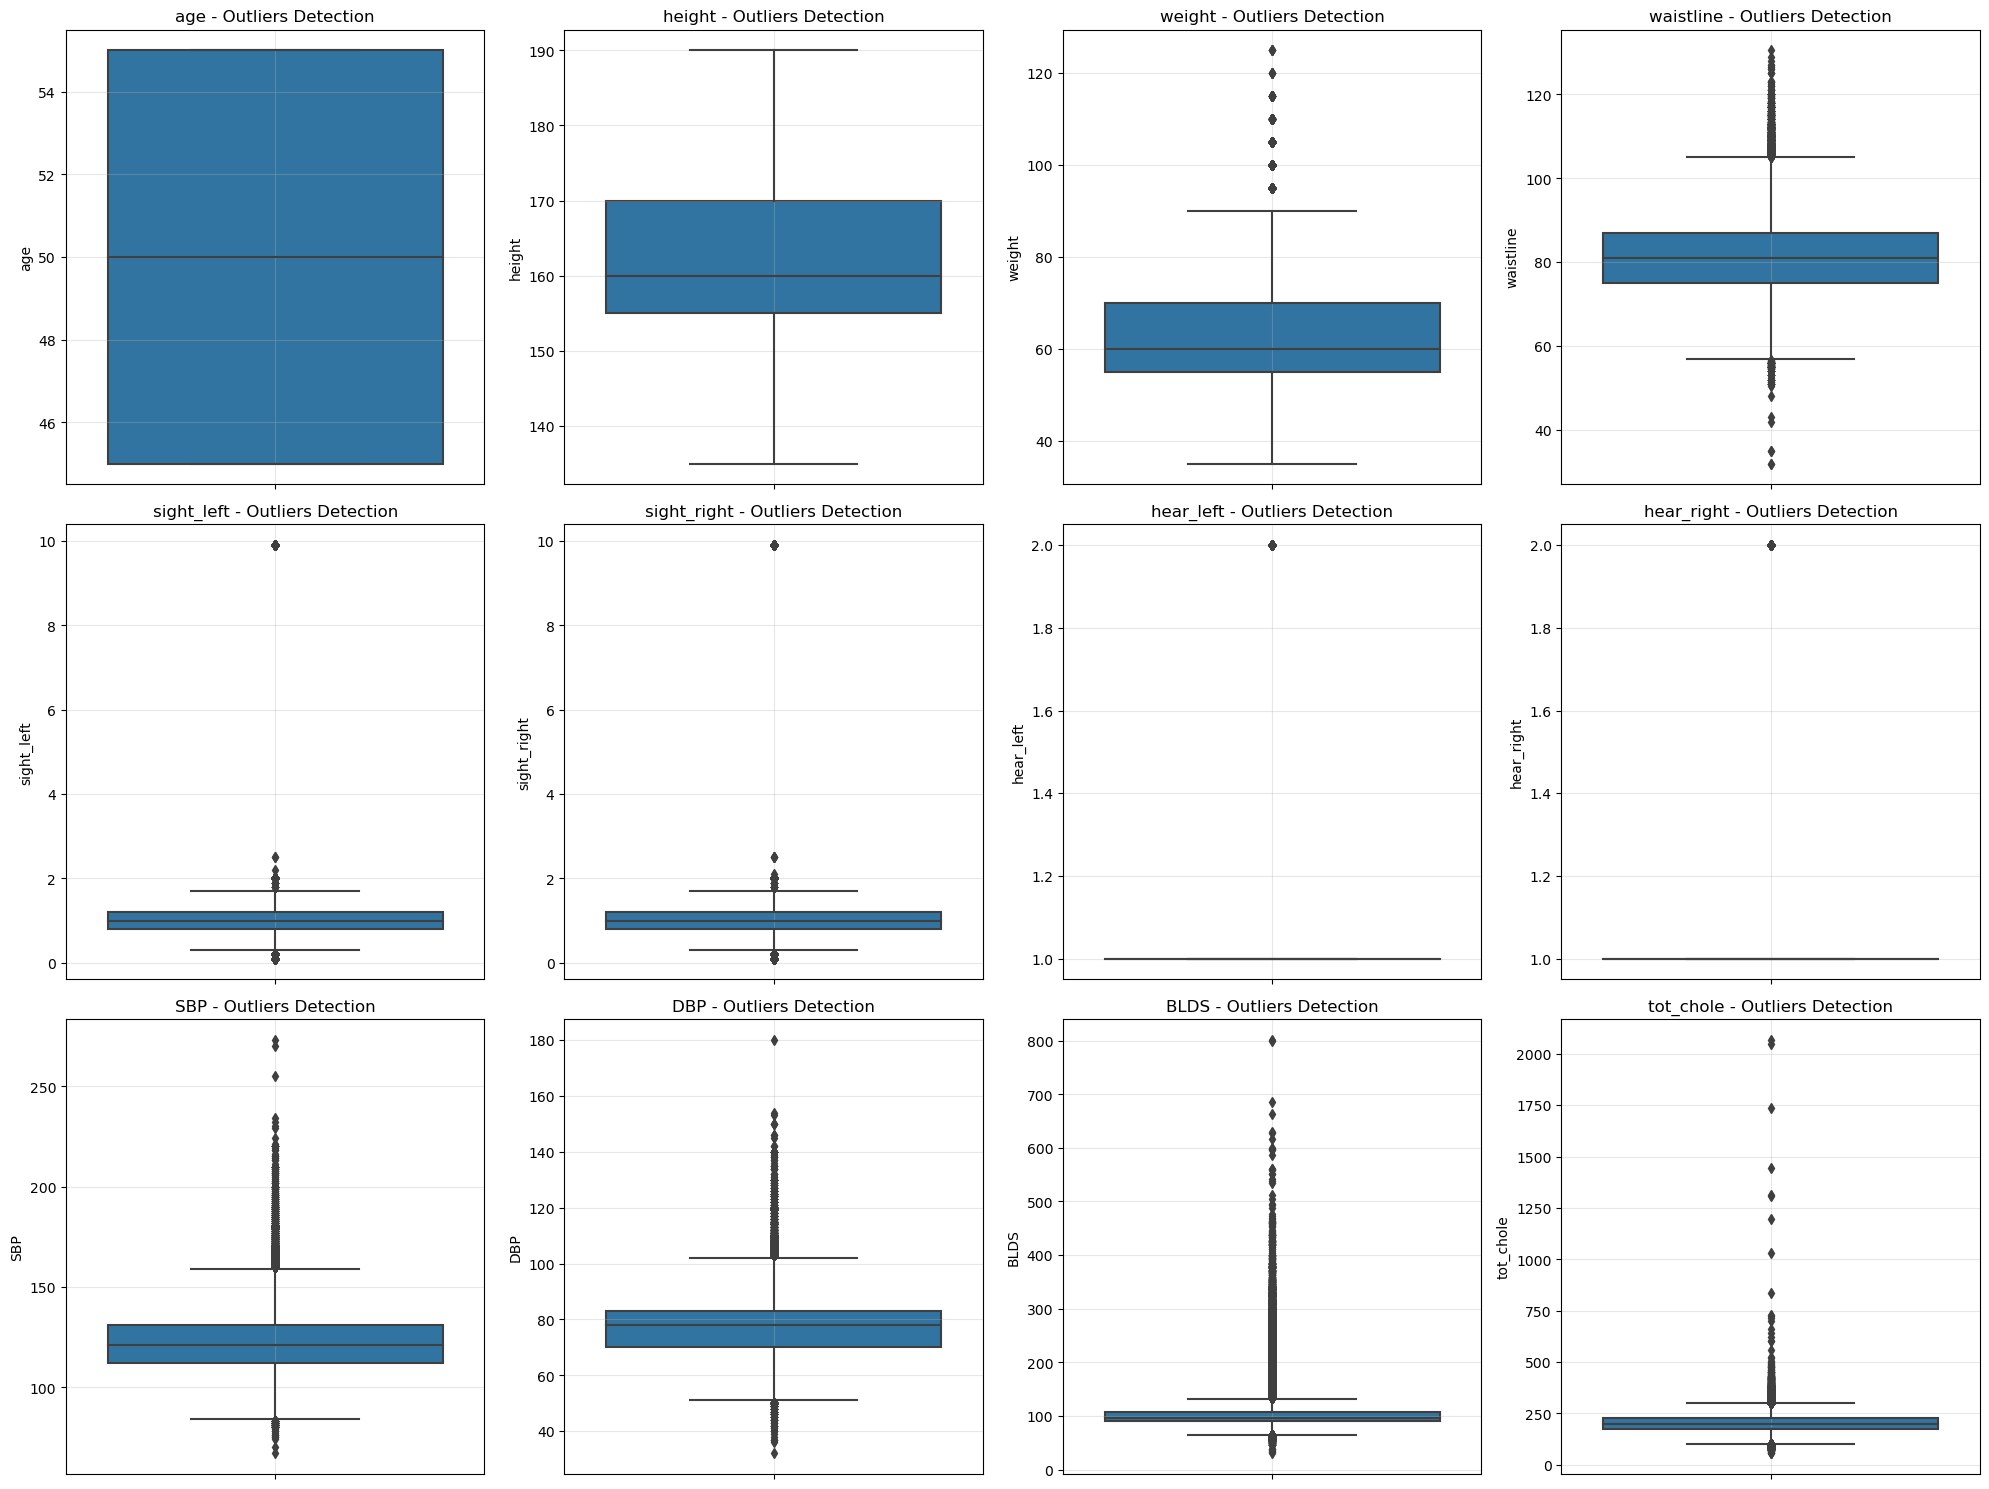

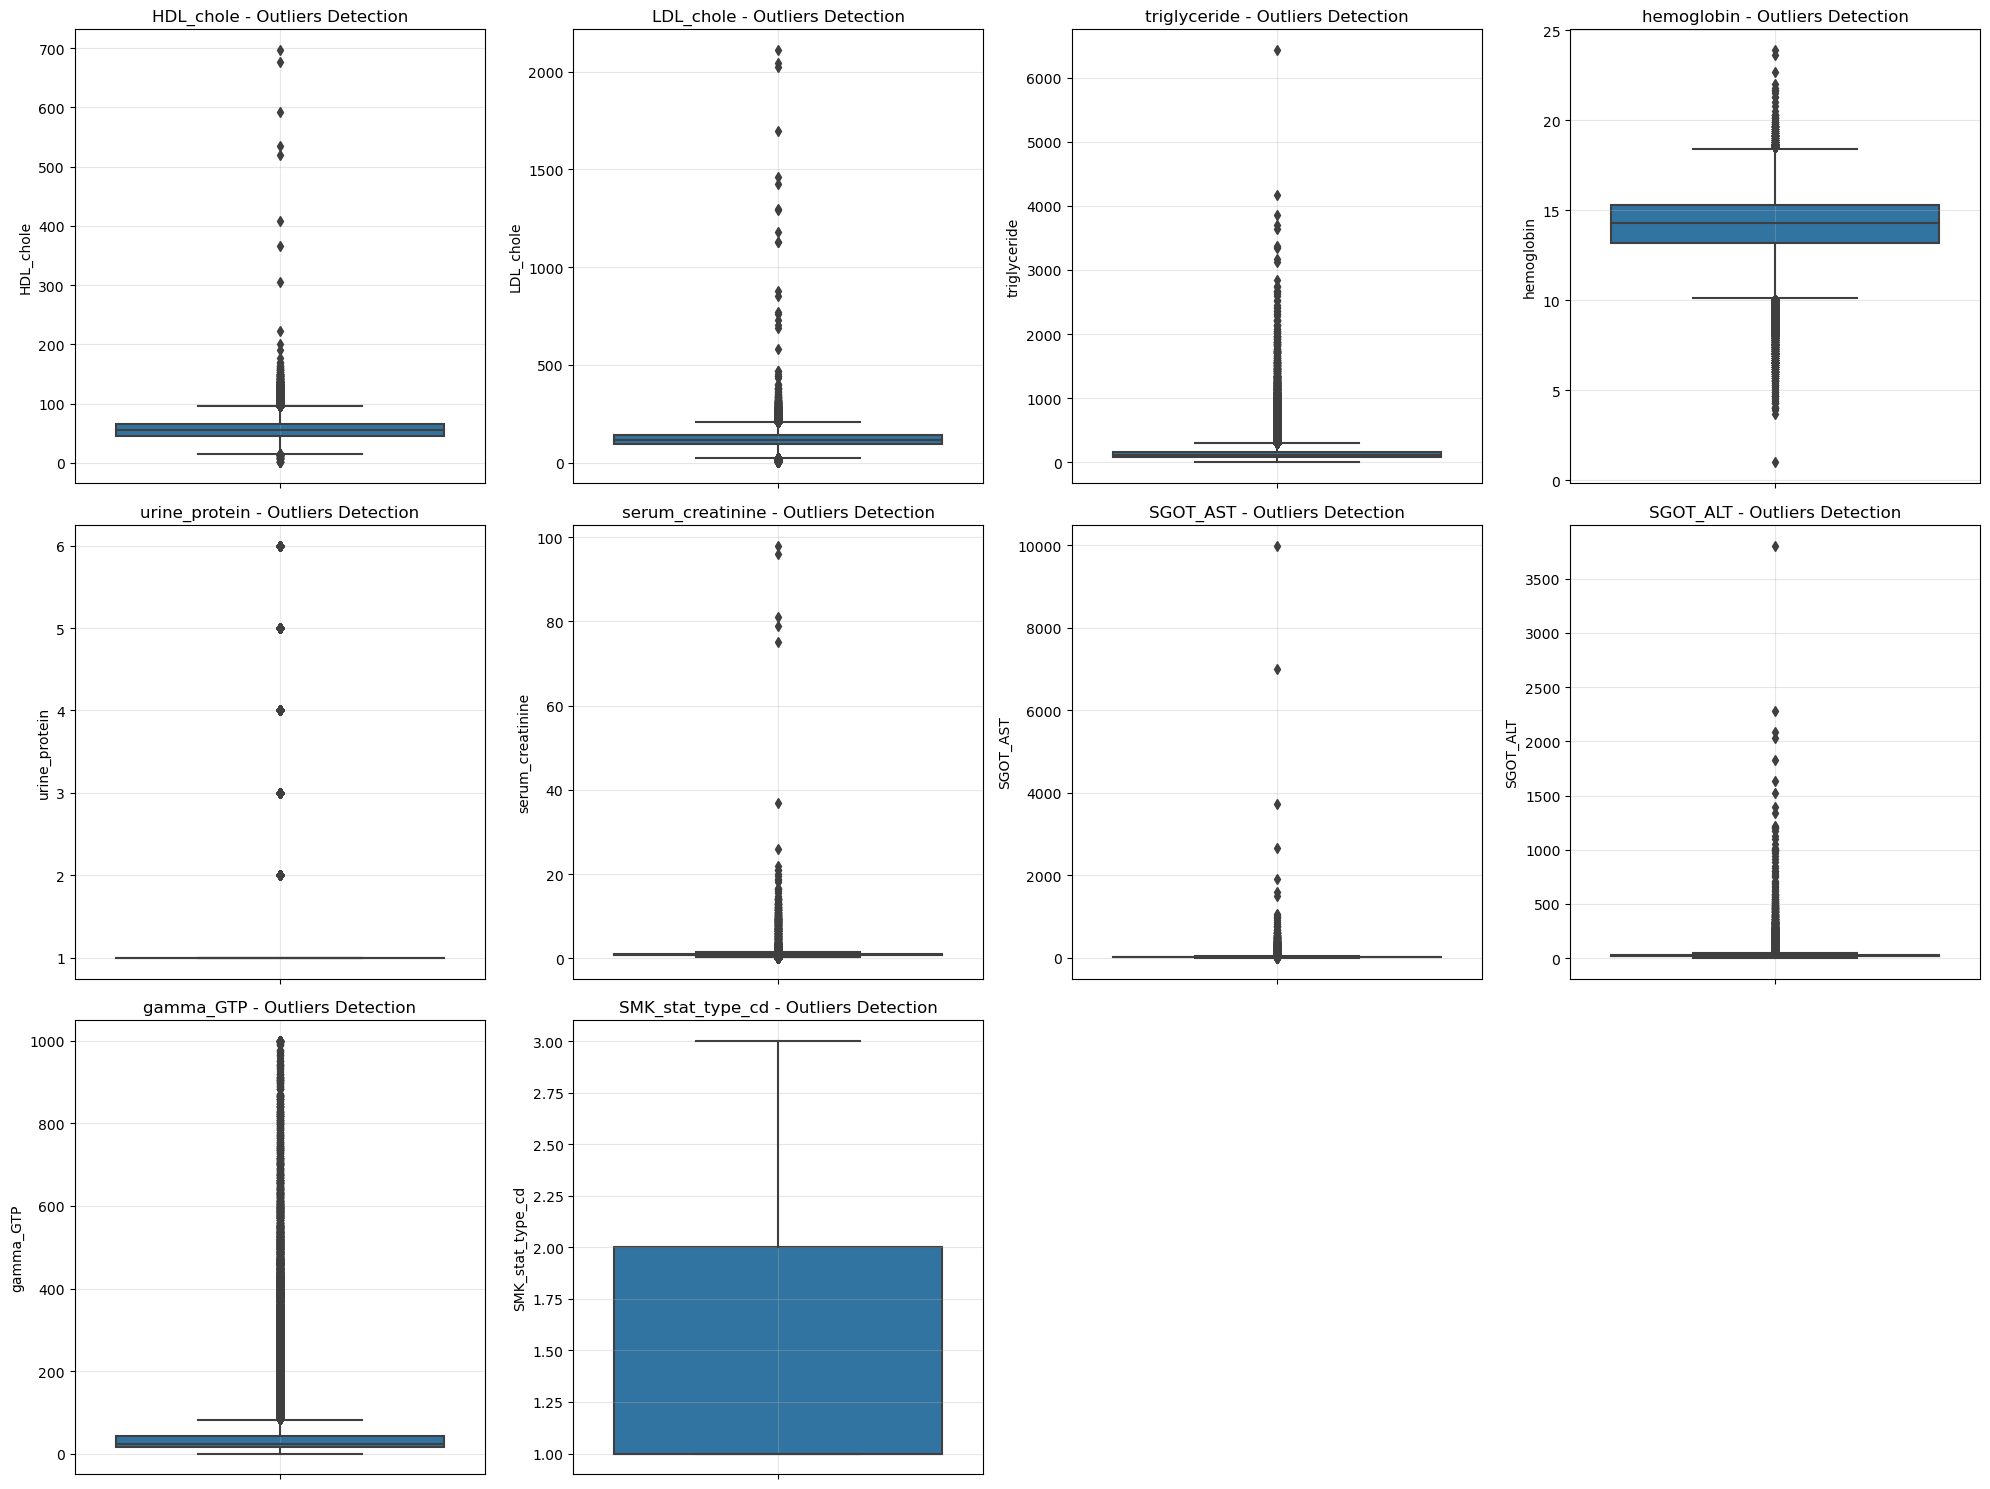

In [120]:
# Create visualizations for outliers
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:12]):  # Show first 12 numerical columns
    # Calculate outlier bounds for this column
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create box plot
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'{col} - Outliers Detection')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create additional plots for remaining numerical columns if any
if len(numerical_cols) > 12:
    remaining_cols = numerical_cols[12:]
    n_remaining = len(remaining_cols)
    n_cols = 4
    n_rows = (n_remaining + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_remaining == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(remaining_cols):
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'{col} - Outliers Detection')
        axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [121]:
# --- Variable groups from dataset documentation ---
CONTINUOUS_VARS = [
    "age", "height", "weight", "sight_left", "sight_right",
    "SBP", "DBP", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
    "triglyceride", "hemoglobin", "serum_creatinine",
    "SGOT_AST", "SGOT_ALT", "gamma_GTP", "waistline"
]

ORDINAL_VARS = ["urine_protein"]  # exclude from IQR
CATEGORICAL_VARS = ["sex", "hear_left", "hear_right", "SMK_stat_type_cd", "DRK_YN"]

# Use intersection with actual columns
cont_cols = [c for c in CONTINUOUS_VARS if c in df.columns]

def iqr_bounds(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return low, high

In [122]:
# Remove (clear errors)

df_clean = df.copy()

REMOVE_RULES = {
    "waistline": lambda s: s > 200,  # e.g., 1000 cm entries
    "serum_creatinine": lambda s: s > 20,  # mg/dL, implausible highs
    "SGOT_AST": lambda s: s > 9000,  # extreme enzyme typos
    "SGOT_ALT": lambda s: s > 9000,
    "sight_left": lambda s: s >= 5,  # 10.0 eyesight entries -> remove
    "sight_right": lambda s: s >= 5,
}

# Apply removal rules
mask_keep = pd.Series(True, index=df_clean.index)
remove_report = []
for col, rule in REMOVE_RULES.items():
    if col in df_clean.columns:
        bad = rule(pd.to_numeric(df_clean[col], errors="coerce"))
        n_bad = int(bad.sum())
        if n_bad > 0:
            mask_keep &= ~bad
            remove_report.append((col, n_bad))

df_clean = df_clean.loc[mask_keep]
print("Rows removed (by column):", remove_report)

# =========================
# 2) CAP (winsorize at IQR)
# =========================
cap_report = []
for col in cont_cols:
    if col in df_clean.columns:
        low, high = iqr_bounds(df_clean[col])
        before = pd.to_numeric(df_clean[col], errors="coerce")
        n_low = int((before < low).sum())
        n_high = int((before > high).sum())
        df_clean[col] = before.clip(lower=low, upper=high)
        cap_report.append({
            "column": col,
            "capped_low": n_low,
            "capped_high": n_high
        })

print(pd.DataFrame(cap_report))

# ==============================
# 3) TRANSFORM (reduce skew with log1p)
# ==============================
LOG1P_VARS = [
    v for v in [
        "weight", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
        "triglyceride", "SGOT_AST", "SGOT_ALT", "gamma_GTP"
    ]
    if v in df_clean.columns
]

transform_report = []
for col in LOG1P_VARS:
    x = pd.to_numeric(df_clean[col], errors="coerce")
    n_neg = int((x < 0).sum())
    if n_neg:
        x = x.clip(lower=0)  # ensure non-negative before log1p
    df_clean[col] = np.log1p(x)
    transform_report.append({
        "column": col,
        "negatives_clipped": n_neg
    })

print(pd.DataFrame(transform_report))


Rows removed (by column): [('serum_creatinine', 10), ('SGOT_AST', 1), ('sight_left', 823), ('sight_right', 813)]
              column  capped_low  capped_high
0                age           0            0
1             height           0            0
2             weight           0         3556
3         sight_left        5487         2350
4        sight_right        5696         1906
5                SBP         159         5064
6                DBP         304         3735
7               BLDS         546        24176
8          tot_chole         487         3633
9          HDL_chole          53         4964
10         LDL_chole         628         3393
11      triglyceride           0        19863
12        hemoglobin        4445          443
13  serum_creatinine         194         1731
14          SGOT_AST          21        20725
15          SGOT_ALT           0        24467
16         gamma_GTP           0        31916
17         waistline         186         2058
         colu

# Feature extracting

Feature extraction after stabilizing data:

In [123]:
# Derived features (feature extraction)
df_clean['BMI'] = df_clean['weight'] / (df_clean['height'] / 100) ** 2
df_clean['pulse_pressure'] = df_clean['SBP'] - df_clean['DBP']
df_clean['LDL_to_HDL'] = df_clean['LDL_chole'] / df_clean['HDL_chole']
df_clean['TG_to_HDL'] = df_clean['triglyceride'] / df_clean['HDL_chole']
df_clean['sight_avg'] = (df_clean['sight_left'] + df_clean['sight_right']) / 2
df_clean['hearing_avg'] = (df_clean['hear_left'] + df_clean['hear_right']) / 2

Data Transformation

In [124]:
# Make a copy to avoid changing the original dataset
df_encoded = df_clean.copy()
df_encoded.drop(columns=['hear_left','hear_right','sight_left','sight_right'], inplace=True)

# Ordinal encoding: urine_protein (1 to 6 is ordered)
df_encoded["urine_protein"] = df_encoded["urine_protein"].astype(int)

# One-hot encoding for nominal variables
nominal_vars = ["sex", "SMK_stat_type_cd", "DRK_YN"]

df_encoded = pd.get_dummies(df_encoded, columns=nominal_vars, drop_first=True)

# Show only the newly created encoded columns
encoded_cols = [col for col in df_encoded.columns if any(var in col for var in nominal_vars)] + ["urine_protein"]
print(df_encoded[encoded_cols].head())


   sex_Male  SMK_stat_type_cd_2.0  SMK_stat_type_cd_3.0  DRK_YN_Y  \
0         1                     0                     0         0   
1         1                     0                     0         0   
2         1                     0                     1         1   
3         0                     0                     0         0   
4         1                     0                     0         1   

   urine_protein  
0              1  
1              1  
2              3  
3              1  
4              1  


Feature scaling

In [125]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown

# Columns to show
cols_to_show = ["age", "weight", "waistline", "SBP", "triglyceride"]

# Before scaling
summary_before = df_encoded[cols_to_show].describe().round(2)

# After scaling
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[cols_to_show] = scaler.fit_transform(df_encoded[cols_to_show])
summary_after = df_scaled[cols_to_show].describe().round(2)

# Display summaries neatly in notebook
display(Markdown("### Summary statistics before scaling"))
display(summary_before)

display(Markdown("### Summary statistics after standardization (Z-score)"))
display(summary_after)


### Summary statistics before scaling

,age,weight,waistline,SBP,triglyceride
count,357501.0,357501.00,357501.00,357501.00,357501.00
mean,49.9,4.14,81.10,122.35,4.75
std,4.0,0.18,8.93,13.81,0.53
min,45.0,3.58,57.00,83.50,0.69
25%,45.0,4.03,75.00,112.00,4.37
50%,50.0,4.11,81.00,121.00,4.73
75%,55.0,4.26,87.00,131.00,5.12
max,55.0,4.54,105.00,159.50,5.71


### Summary statistics after standardization (Z-score)

,age,weight,waistline,SBP,triglyceride
count,357501.00,357501.00,357501.00,357501.00,357501.00
mean,-0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.22,-3.17,-2.70,-2.81,-7.67
25%,-1.22,-0.67,-0.68,-0.75,-0.71
50%,0.03,-0.19,-0.01,-0.10,-0.03
75%,1.28,0.67,0.66,0.63,0.72
max,1.28,2.23,2.68,2.69,1.82


Data splitting

In [126]:
# Set 'DRK_YN' (Drinker or Not) as target variable — use the encoded dataframe
# If one-hot encoding created "DRK_YN_Y", use that as your target
target_col = "DRK_YN_Y" if "DRK_YN_Y" in df_encoded.columns else "DRK_YN"

# Separate features (X) and label (y)
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Split the data into training and testing sets (80–20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape (X_train):", X_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Training set shape (y_train):", y_train.shape)
print("Testing set shape (y_test):", y_test.shape)

Training set shape (X_train): (286000, 26)
Testing set shape (X_test): (71501, 26)
Training set shape (y_train): (286000,)
Testing set shape (y_test): (71501,)


In [127]:
df_encoded

,age,height,weight,waistline,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,BMI,pulse_pressure,LDL_to_HDL,TG_to_HDL,sight_avg,hearing_avg,sex_Male,SMK_stat_type_cd_2.0,SMK_stat_type_cd_3.0,DRK_YN_Y
0,50,175,4.394449,91.0,145.0,87.0,4.564348,5.308268,4.343805,4.653960,4.672829,17.6,1,1.1,3.401197,3.555348,2.944439,1.434922,58.0,1.071402,1.075745,1.35,1.0,1,0,0,0
1,50,165,4.110874,80.0,138.0,82.0,4.624973,5.298317,4.127134,4.770685,4.653960,13.8,1,0.8,2.995732,2.564949,3.258097,1.509963,56.0,1.155931,1.127649,1.10,1.0,1,0,0,0
2,50,165,4.025352,75.0,142.0,92.0,4.605170,5.389072,4.356709,4.564348,5.451038,13.8,3,0.8,3.401197,3.713572,3.637586,1.478550,50.0,1.047660,1.251183,1.35,1.0,1,0,1,1
3,45,150,4.025352,69.0,101.0,58.0,4.499810,5.283204,4.204693,4.753590,4.330733,12.3,1,0.8,2.995732,2.564949,2.564949,1.789045,43.0,1.130544,1.029976,0.45,1.0,0,0,0,0
4,55,170,4.330733,84.0,145.0,85.0,4.653960,5.384495,4.043051,4.955827,4.615121,15.1,1,0.8,3.496508,3.178054,3.295837,1.498524,60.0,1.225764,1.141494,1.05,1.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359007,50,150,4.110874,85.0,104.0,73.0,4.454347,5.159055,3.951244,4.564348,4.897840,13.3,1,0.7,3.091042,3.044522,3.433987,1.827055,31.0,1.155167,1.239569,0.90,1.0,0,0,0,0
359008,45,165,4.025352,68.2,123.0,80.0,4.488636,5.398163,4.406719,4.859812,4.025352,11.8,1,0.6,2.995732,2.484907,2.197225,1.478550,43.0,1.102819,0.913458,1.10,1.0,0,0,0,0
359009,50,150,3.931826,72.6,116.0,74.0,4.691348,5.187386,3.891820,4.663439,4.836282,15.2,1,0.8,3.367296,3.295837,3.401197,1.747478,42.0,1.198267,1.242679,1.00,1.0,0,0,0,0
359010,45,175,4.394449,92.1,114.0,80.0,4.488636,5.293305,3.850148,4.836282,4.890349,15.0,1,1.0,3.295837,3.610918,3.332205,1.434922,34.0,1.256129,1.270172,1.50,1.0,1,0,0,0


### Correlation filter

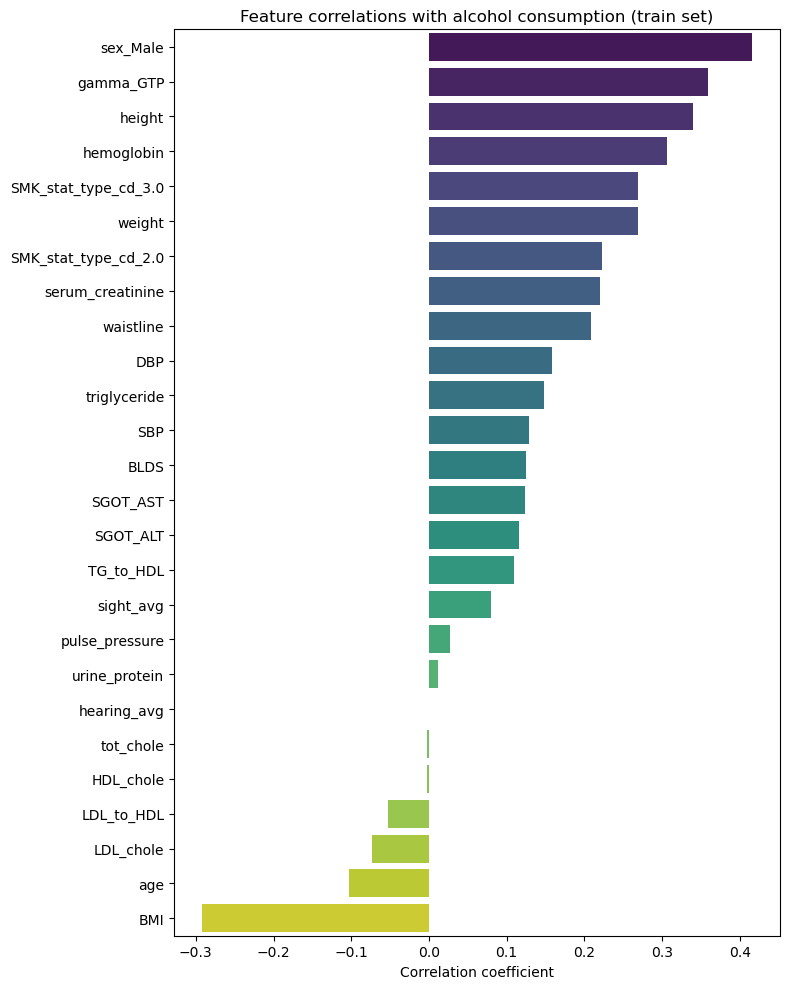

Kept after correlation filter: ['sex_Male', 'gamma_GTP', 'height', 'hemoglobin', 'SMK_stat_type_cd_3.0', 'weight', 'SMK_stat_type_cd_2.0', 'serum_creatinine', 'waistline', 'DBP', 'triglyceride', 'SBP', 'BLDS', 'SGOT_AST', 'SGOT_ALT', 'TG_to_HDL', 'sight_avg', 'LDL_to_HDL', 'LDL_chole', 'age', 'BMI']


In [128]:
# --- Step 1 Correlation-based filtering ---
corr_df = X_train.copy()
corr_df['target'] = y_train

corr_matrix = corr_df.corr(numeric_only=True)
corr_with_target = corr_matrix['target'].drop('target').sort_values(ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="viridis")
plt.title("Feature correlations with alcohol consumption (train set)")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.show()

selected_corr_features = corr_with_target[abs(corr_with_target) > 0.05].index.tolist()
print("Kept after correlation filter:", selected_corr_features)

In [ ]:
# --- SAMPLE for faster feature selection ---
# Use only 10–15% of data for RFE (same feature relationships, far less compute)
X_sample = X_train.sample(frac=0.15, random_state=42)
y_sample = y_train.loc[X_sample.index]

# --- LIGHTER RandomForest for selection ---
rf_estimator = RandomForestClassifier(
    n_estimators=300,  # fewer trees = faster
    random_state=42,
    n_jobs=-1
)

# --- RFE wrapper ---
rfe = RFE(estimator=rf_estimator, n_features_to_select=10, step=1)
rfe.fit(X_sample[selected_corr_features], y_sample)

selected_features = X_sample[selected_corr_features].columns[rfe.support_].tolist()
print("\nFinal selected features by RFE:\n", selected_features)

# --- Importance scores for selected features ---
importance_scores = pd.Series(
    rfe.estimator_.feature_importances_,
    index=X_sample[selected_corr_features].columns[rfe.support_]
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importance_scores.values, y=importance_scores.index, palette="magma")
plt.title("Feature Importance (Random Forest - RFE, sample subset)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Save selection for reproducibility
pd.Series(selected_features, name="selected_features").to_csv("selected_features.csv", index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train[selected_features], y_train)

y_pred = log_reg.predict(X_test[selected_features])
y_prob = log_reg.predict_proba(X_test[selected_features])[:, 1]

log_reg_results = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(pd.DataFrame([log_reg_results]))

                 Model  Accuracy        F1   ROC-AUC
0  Logistic Regression  0.709575  0.707825  0.771641


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

# --- Decision Tree ---
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train[selected_features], y_train)

y_pred = tree.predict(X_test[selected_features])
y_prob = tree.predict_proba(X_test[selected_features])[:, 1]

tree_results = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(pd.DataFrame([tree_results]))

           Model  Accuracy        F1  ROC-AUC
0  Decision Tree  0.610759  0.607328  0.61073


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train[selected_features], y_train)

y_pred = rf.predict(X_test[selected_features])
y_prob = rf.predict_proba(X_test[selected_features])[:, 1]

rf_results = {
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(pd.DataFrame([rf_results]))

           Model  Accuracy        F1   ROC-AUC
0  Random Forest  0.706859  0.692838  0.767146


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Downsample for faster testing
X_small = X_train[selected_features].sample(frac=0.1, random_state=42)
y_small = y_train.loc[X_small.index]

# --- SVM ---
svm_model = SVC(kernel='rbf', probability=True, gamma='scale', random_state=42)

svm_model.fit(X_small, y_small)

y_pred = svm_model.predict(X_test[selected_features])
y_prob = svm_model.predict_proba(X_test[selected_features])[:, 1]

svm_results = {
    "Model": "SVM (RBF Kernel)",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}
print(svm_results)

{'Model': 'SVM (RBF Kernel)', 'Accuracy': 0.7018066192098782, 'F1': 0.7043970468968169, 'ROC-AUC': 0.7477515978007409}


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- Neural Network ---
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, early_stopping=True, random_state=42)

nn_model.fit(X_train[selected_features], y_train)

y_pred = nn_model.predict(X_test[selected_features])
y_prob = nn_model.predict_proba(X_test[selected_features])[:, 1]

nn_results = {
    "Model": "Neural Network",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}
print(nn_results)

{'Model': 'Neural Network', 'Accuracy': 0.7114638507472757, 'F1': 0.7032957502168257, 'ROC-AUC': 0.7749612391083714}


## TASK 7 - BAGGING N BOOSTING

### Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df_encoded

,age,height,weight,waistline,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,BMI,pulse_pressure,LDL_to_HDL,TG_to_HDL,sight_avg,hearing_avg,sex_Male,SMK_stat_type_cd_2.0,SMK_stat_type_cd_3.0,DRK_YN_Y
0,40,165,4.330733,91.0,120.0,70.0,4.595120,4.919981,3.737670,4.317488,4.653960,15.8,1,0.9,3.806662,3.496508,4.234107,1.590719,50.0,1.155128,1.245150,1.35,1.0,1,0,0,0
1,50,175,4.394449,91.0,145.0,87.0,4.564348,5.308268,4.343805,4.653960,4.672829,17.6,1,1.1,3.401197,3.555348,2.944439,1.434922,58.0,1.071402,1.075745,1.35,1.0,1,0,0,0
2,50,165,4.110874,80.0,138.0,82.0,4.624973,5.298317,4.127134,4.770685,4.653960,13.8,1,0.8,2.995732,2.564949,3.258097,1.509963,56.0,1.155931,1.127649,1.10,1.0,1,0,0,0
3,50,165,4.025352,75.0,142.0,92.0,4.605170,5.389072,4.356709,4.564348,5.451038,13.8,3,0.8,3.401197,3.713572,3.637586,1.478550,50.0,1.047660,1.251183,1.35,1.0,1,0,1,1
4,45,150,4.025352,69.0,101.0,58.0,4.499810,5.283204,4.204693,4.753590,4.330733,12.3,1,0.8,2.995732,2.564949,2.564949,1.789045,43.0,1.130544,1.029976,0.45,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595455,60,150,4.189655,83.0,122.0,74.0,4.499810,5.541264,4.394449,5.036953,4.615121,13.1,1,0.6,3.401197,3.178054,3.044522,1.862069,48.0,1.146208,1.050216,0.75,1.0,0,1,0,1
595456,50,150,3.931826,72.6,116.0,74.0,4.691348,5.187386,3.891820,4.663439,4.836282,15.2,1,0.8,3.367296,3.295837,3.401197,1.747478,42.0,1.198267,1.242679,1.00,1.0,0,0,0,0
595457,45,175,4.394449,92.1,114.0,80.0,4.488636,5.293305,3.850148,4.836282,4.890349,15.0,1,1.0,3.295837,3.610918,3.332205,1.434922,34.0,1.256129,1.270172,1.50,1.0,1,0,0,0
595458,40,155,3.931826,68.0,110.0,70.0,4.510860,5.327876,4.548600,4.356709,5.062595,14.3,1,0.8,3.433987,3.332205,2.890372,1.636556,40.0,0.957813,1.113001,0.85,1.0,0,0,1,1


### Split and fix

In [ ]:
X = df_encoded.drop(columns=['DRK_YN_Y'])
y = df_encoded['DRK_YN_Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Bagging

In [ ]:
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
bag_model.fit(X_train, y_train)
y_pred_bag = bag_model.predict(X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)

### Boosting

In [ ]:
# adaboost boosting
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
acc_ada = accuracy_score(y_test, y_pred_ada)

# gradient boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)

### Results

In [ ]:
print("Bagging accuracy:", acc_bag)
print("AdaBoost accuracy:", acc_ada)
print("Gradient Boosting accuracy:", acc_gb)

Bagging accuracy: 0.7164147633345703
AdaBoost accuracy: 0.725152660166661
Gradient Boosting accuracy: 0.7326254174960359


## TRANSFER LEARNING Task 8